In [ ]:
!sudo apt-get update
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install pyglet
!pip install imageio-ffmpeg

In [3]:
import base64
import imageio
import IPython
import PIL.Image
from moviepy.video.io.bindings import mplfig_to_npimage
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict

In [87]:
class enviornment:
  def __init__(self):
    print('initialize env')
    self.grid= np.zeros((21, 21))
    self.total_user_distribution=self.users_generator()
    self.state=self.reset() #for q1 
    # self.battery=40
    # self.Done=False
    # self.history=[]


  def users_generator(self):
    total_user_distribution=[]
    for i in [[17,4,5,40],[12,6,4,15],[6,15,4,15],[15,15,5,20],[7,16,3,20]]:
      
      x,y,std,num=i[0],i[1],i[2],i[3]
      X=np.abs(np.random.normal(x,std,num))
      Y=np.abs(np.random.normal(y,std,num))
      user_distribution=[]
    
      for k, (i,j) in enumerate(zip(X,Y),):
        if i >20:
          X[k]=20-(i-20)
        if j>20:
          Y[k]=40-j 
        
      for i,j in zip(X,Y):
        if i>=7 and i<= 9 and j>=18 :
          continue
        if i>=8 and i<= 14 and j>=10 and j<=13 :
          continue
        user_distribution.append((i,j))
      total_user_distribution.append(user_distribution)
    
    return total_user_distribution
  
  #creat image
  def render(self,Title="",state=(0,0),optimal_path=[],path_plot=False):
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"]=(10,9)
    ax.imshow(self.grid, cmap='Greys',origin='lower')
    rect = patches.Rectangle((7, 18), 2, 2, linewidth=2, edgecolor='black', facecolor='green')
    ax.add_patch(rect) 
    rect = patches.Rectangle((8, 10), 6, 3, linewidth=2, edgecolor='black', facecolor='red')
    ax.add_patch(rect) 
    plt.text(9.5, 11.2, "No Fly Zone", color='Black', fontsize=14)
    plt.text(7.7, 18.7, "SL", color='Black', fontsize=14)
    plt.xticks(np.arange(0, 21, 1),np.arange(0, 21, 1))
    plt.yticks(np.arange(0, 21, 1),np.arange(0, 21, 1))
    plt.title(Title)
    plt.grid()


    for t,symbol in zip(self.total_user_distribution,['x','o','*','#','+']):
        for i in t:
          plt.text(i[0], i[1], symbol, color='Black', fontsize=11)

    rect = patches.Rectangle((state[0]-1.5, state[1]-1.5), 3, 3, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    if path_plot:
      for state, next_state in optimal_path:
        plt.arrow(state[0],state[1],0.9*(next_state[0]-state[0]), 0.9*(next_state[1]-state[1]),head_width=0.1, color='Red',width=0.01)

    #plt.show()
    plt.close()
    return fig
  
  

  def is_outoff_grid(self,i, j):
      if i < 0 or i > 20 or j < 0 or j > 20:
          return True
      elif i>=8 and i<= 14 and j>=10 and j<=13 :
          return True
      else:
          return False

  def surveillance(self,total_user_distribution,xnow,ynow,xnext,ynext,history):
  
    coverd_users_now=[]
    coverd_users_next=[]
    if (xnow,ynow) not in history:
        
        xmax=xnow+1.5
        xmin=xnow-1.5
        ymax=ynow+1.5
        ymin=ynow-1.5
        for t in self.total_user_distribution:
          for i in t:
            
            if i[0]<=xmax and i[0]>=xmin and i[1]<=ymax and i[1]>=ymin:
              coverd_users_now.append((i[0],i[1]))
    
    if (xnext,ynext) not in history:
        
        xmax=xnext+1.5
        xmin=xnext-1.5
        ymax=ynext+1.5
        ymin=ynext-1.5
        for t in self.total_user_distribution:
          for i in t:
            
            if i[0]<=xmax and i[0]>=xmin and i[1]<=ymax and i[1]>=ymin:
              coverd_users_next.append((i[0],i[1]))
              
              #print(i[0],i[1])
    return len(list(set(coverd_users_next) - set(coverd_users_now)))  #when overlap only count the new people found


  def step(self,state, action):
      
      self.battery+=-1
      captured_ppl=0
      # take one step
      i, j = state[0]+3*action[0], state[1]+3*action[1]

      # check if the next state is out off grid
      if self.is_outoff_grid(i, j):
          # if it is out of grid the agent stays in the cell it was before
          i, j = state[0], state[1]
          reward=-5
          if self.battery==0:
            Done=True 
          return (i,j), reward,self.Done,captured_ppl

      if i >=7 and i <= 9 and j>=18 and j<=20 :
          if self.battery<10:
            reward = 10
          else:
            reward=1
          self.Done=True
          return (i,j), reward,self.Done,captured_ppl
      else:
          captured_ppl=self.surveillance(self.total_user_distribution,state[0],state[1],i,j,self.history)  #current state and next state will be consdiered
          reward =captured_ppl-1
          if (i,j) in self.history:
            reward=-6
          if self.battery==0:
            self.Done=True 
      return (i,j), reward,self.Done,captured_ppl

  def reset(self):
    self.state=(0,0) #q1
    Xint=np.random.choice([0, 1, 2])
    Yint=np.random.choice([0, 1, 2])

    #self.state=(Xint,Yint)  #for Q2,Q3,Q4
    self.battery=40
    self.Done=False
    self.history=[]
    
    return self.state 
  

In [88]:
#policy
def epsilon_greedy_policy(state, Q, epsilon=0.1):

    # set the epsilon value to 0.5
    #epsilon = 0.5

    # sample a random value from the uniform distribution, if the sampled value is less than
    # epsilon then we select a random action else we select the best action which has maximum Q
    # value as shown below

    if np.random.rand() < epsilon:
        return np.random.choice([0, 1, 2, 3])  # gives index
    else:
        t = []
        # iterate through the actions
        for action in actions:
            t.append(Q[(state, action)])
        return np.random.choice([index for index in range(len(t)) if t[index] == max(t)])
        
def update_epsilon(epsilon, min_epsilon, epsilon_step):
  if (epsilon > min_epsilon):
      epsilon -= epsilon_step
  return epsilon

In [81]:
  
#video maker
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [89]:
##parameters 

actions=([(0, 1), (0,-1), (-1,0), (1,0)])  #up,down,left,right
Q = defaultdict(float)
episodes=500
min_epsilon = 0.05
epsilon = 0.1  # starting exploration rate
epsilon_step = 10/episodes
video=imageio.get_writer("final.mp4", fps=3)

In [91]:
##Run Q Learning

env=enviornment()
store_captured_ppl=[]

# for each iteration
for i in range(episodes):
    print('episode', i+1)

    # generate an episode using our policy π
    state=env.state

    # for each step in the episode
    steps = 0
    optimal_path = []
    env.history.append(state)
    
    total_captured_ppl=0
    
    

    while not env.Done:
        steps += 1
        #print('steps', steps)

        action = actions[epsilon_greedy_policy(state, Q,epsilon)]

        # if i==500:
        #   action = actions[epsilon_greedy_policy(state, Q, 0.2)]
        # if i==750:
        #   action = actions[epsilon_greedy_policy(state, Q,0.1)]
        # if i==900:
        #   action = actions[epsilon_greedy_policy(state, Q,0.01)]

        next_state, R, Done, captured_ppl = env.step(state, action)
        total_captured_ppl+=captured_ppl

        if next_state not in env.history:
          env.history.append(next_state)

        print('state', state, 'action', action,'next_state', next_state, 'reward',R,'battery',env.battery,'Done',Done)
        optimal_path.append([state, next_state])

        #render(next_state)
        if (i+1)%25==0:  # creat video from the last episode
          x=env.render("Episdoe %d"%i, state)
          numpy_fig = mplfig_to_npimage(x)
          video.append_data(numpy_fig)

        # next_action=actions[epsilon_greedy_policy(next_state,Q)]
        t = []
        # iterate through the actions
        for a in actions:
            t.append(Q[(next_state, a)])
        Q[(state, action)] += 0.5*(R+max(t)-Q[(state, action)])

        state = next_state
    
    store_captured_ppl.append(total_captured_ppl)
    if (i+1)%25==0:
      x=env.render("Episdoe %d , People found= %d "%(i,total_captured_ppl), state)
      numpy_fig = mplfig_to_npimage(x)
      video.append_data(numpy_fig)
    
    #epsilon=update_epsilon(epsilon, min_epsilon, epsilon_step) #epsilon decay
    #epsilon=min((1/(0.5*episodes*total_captured_ppl)),1)
    print("total captured people",total_captured_ppl, "epsilon changed to ",epsilon)
    
    #render(state)
    env.reset()


video.close()
embed_mp4("final.mp4")        

        # if steps>1000:
        # break
 

episode 1
state (0, 0) action (-1, 0) next_state (0, 0) reward -5 battery 39 Done False
state (0, 0) action (1, 0) next_state (3, 0) reward -1 battery 38 Done False
state (3, 0) action (-1, 0) next_state (0, 0) reward -6 battery 37 Done False
state (0, 0) action (0, -1) next_state (0, 0) reward -5 battery 36 Done False
state (0, 0) action (0, 1) next_state (0, 3) reward -1 battery 35 Done False
state (0, 3) action (-1, 0) next_state (0, 3) reward -5 battery 34 Done False
state (0, 3) action (1, 0) next_state (3, 3) reward -1 battery 33 Done False
state (3, 3) action (0, -1) next_state (3, 0) reward -6 battery 32 Done False
state (3, 0) action (1, 0) next_state (6, 0) reward -1 battery 31 Done False
state (6, 0) action (0, 1) next_state (6, 3) reward 0 battery 30 Done False
state (6, 3) action (0, -1) next_state (6, 0) reward -6 battery 29 Done False
state (6, 0) action (0, 1) next_state (6, 3) reward -6 battery 28 Done False
state (6, 3) action (-1, 0) next_state (3, 3) reward -6 batte

Streaming output truncated to the last 5000 lines.
state (0, 6) action (0, 1) next_state (0, 9) reward 0 battery 37 Done False
state (0, 9) action (0, 1) next_state (0, 12) reward 1 battery 36 Done False
state (0, 12) action (1, 0) next_state (3, 12) reward 1 battery 35 Done False
state (3, 12) action (0, 1) next_state (3, 15) reward 1 battery 34 Done False
state (3, 15) action (0, 1) next_state (3, 18) reward 1 battery 33 Done False
state (3, 18) action (1, 0) next_state (6, 18) reward 0 battery 32 Done False
state (6, 18) action (-1, 0) next_state (3, 18) reward -6 battery 31 Done False
state (3, 18) action (1, 0) next_state (6, 18) reward -6 battery 30 Done False
state (6, 18) action (1, 0) next_state (9, 18) reward 1 battery 29 Done True
total captured people 10 epsilon changed to  0.1
episode 207
state (0, 0) action (0, 1) next_state (0, 3) reward -1 battery 39 Done False
state (0, 3) action (1, 0) next_state (3, 3) reward -1 battery 38 Done False
state (3, 3) action (0, 1) next_s

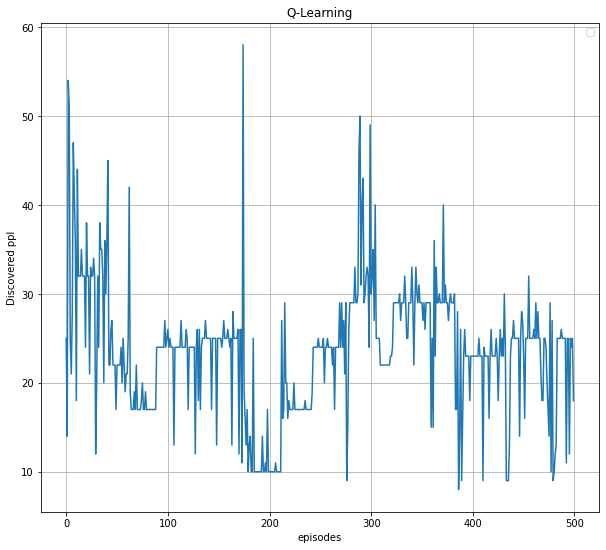

In [92]:
plt.plot(np.arange(episodes), store_captured_ppl)
plt.ylabel('Discovered ppl')
plt.xlabel('episodes')
plt.title('Q-Learning')
plt.legend()
plt.grid()
plt.show()

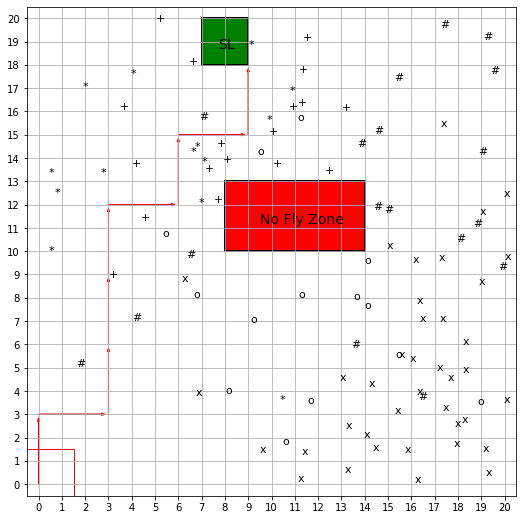

In [93]:
fig=env.render(optimal_path=optimal_path,path_plot=True)
fig